In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import os,re

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/spam-emails")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/abdallahwagih/spam-emails/versions/1


In [ ]:
dataset = path

file_name = os.listdir(dataset)
print(file_name)

data = os.path.join(dataset,"spam.csv")

['spam.csv']


In [ ]:
df = pd.read_csv(data)

In [ ]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.duplicated().sum()

415

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.Category.value_counts()

,count
Category,
ham,4516
spam,641


In [ ]:
df["type"] = df["Category"].map({"ham":0,"spam":1})

In [ ]:
df["type"].value_counts()

,count
type,
0,4516
1,641


In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(
    df['Message'], df['type'], test_size=0.2, random_state=42
)

In [ ]:
ytrain.value_counts()

,count
type,
0,3620
1,505


In [ ]:
ytest.value_counts()

,count
type,
0,896
1,136


In [ ]:
xtrain = xtrain.tolist()
xtest = xtest.tolist()

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenize_xtrain = tokenizer(xtrain,padding=True,truncation=True,max_length=150, return_tensors="tf")
tokenize_xtest = tokenizer(xtest,padding=True,truncation=True,max_length=150, return_tensors="tf")

In [ ]:
tokenize_xtrain

{'input_ids': <tf.Tensor: shape=(4125, 150), dtype=int32, numpy=
array([[  101,  2288, 20933, ...,     0,     0,     0],
       [  101,  2061,  2129, ...,     0,     0,     0],
       [  101,  1045,  2156, ...,     0,     0,     0],
       ...,
       [  101,  4231,  2038, ...,     0,     0,     0],
       [  101,  2057,  2031, ...,     0,     0,     0],
       [  101,  2156,  1010, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(4125, 150), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4125, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.utils import to_categorical

ytrain = to_categorical(ytrain, num_classes=2)
ytest = to_categorical(ytest, num_classes=2)

In [ ]:
# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenize_xtrain),
    tf.convert_to_tensor(ytrain)
)).batch(16)  # Batch size (adjust as needed)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenize_xtest),
    tf.convert_to_tensor(ytest)
)).batch(16)


In [ ]:
train_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 150), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 150), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 150), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

In [ ]:
from transformers import TFBertForSequenceClassification, AdamWeightDecay

# Load BERT model with 2 output classes (Spam / Not Spam)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Use AdamWeightDecay optimizer from transformers
optimizer = AdamWeightDecay(learning_rate=2e-5)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ytrain.shape

(4125, 2)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3  # Increase epochs if needed
)

Epoch 1/3
258/258 [==============================] - 164s 562ms/step - loss: 0.1216 - accuracy: 0.9685 - val_loss: 0.0314 - val_accuracy: 0.9952
Epoch 2/3
258/258 [==============================] - 135s 525ms/step - loss: 0.0276 - accuracy: 0.9937 - val_loss: 0.0223 - val_accuracy: 0.9913
Epoch 3/3
258/258 [==============================] - 136s 525ms/step - loss: 0.0219 - accuracy: 0.9947 - val_loss: 0.0329 - val_accuracy: 0.9922


In [ ]:

import numpy as np

# Get predictions
predictions = model.predict(test_dataset)

# Extract logits (raw model outputs before softmax)
logits = predictions["logits"]  # Correct way to access logits

# Convert logits to class labels
predicted_labels = np.argmax(logits, axis=1)

# Print the predicted labels
print("Predicted Labels:", predicted_labels)

65/65 [==============================] - 17s 180ms/step
Predicted Labels: [0 0 0 ... 0 0 0]


In [ ]:
predicted_labels[1]

0

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

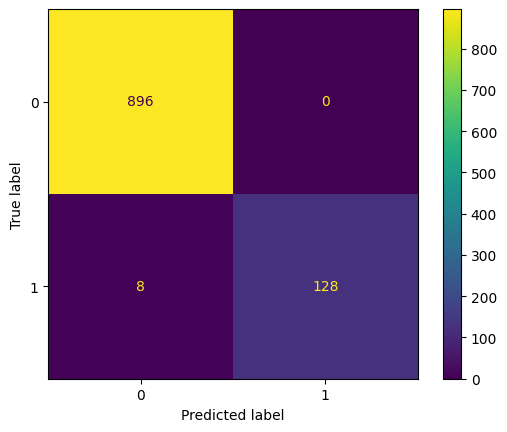

In [ ]:
# ... (previous code)

cm = confusion_matrix(np.argmax(ytest, axis=1), predicted_labels)
# Changed ytest to np.argmax(ytest, axis=1) to match format

ConfusionMatrixDisplay(cm).plot()

In [ ]:
def predict_spam(text):
    # Tokenize input text using the BERT tokenizer
    inputs = tokenizer(text, padding=True, truncation=True, max_length=150, return_tensors="tf")

    # Get model predictions
    preds = model.predict(dict(inputs))

    # Get class index (Spam = 1, Not Spam = 0)
    class_index = tf.argmax(preds.logits, axis=1).numpy()[0]

    return "🔴 Spam" if class_index == 1 else "🟢 Not Spam"


In [ ]:
predict_spam('''
 Subject: Project Meeting Rescheduled
Hi Team,
Due to scheduling conflicts, our project meeting has been rescheduled to Wednesday at 3 PM.
Let me know if this works for everyone.''')

1/1 [==============================] - 9s 9s/step


'🟢 Not Spam'

In [ ]:
predict_spam('''We are pleased to inform you that you have won $1,000,000 USD in our 2025 International Lottery Draw.
To claim your prize, please provide your:''')

1/1 [==============================] - 0s 82ms/step


'🔴 Spam'

In [ ]:
model.save("spam_classifier")


In [ ]:
model.save("spam_classifier1", save_format="tf")

In [ ]:
import shutil

shutil.make_archive("spam_classifier", 'zip', "spam_classifier")
from google.colab import files
files.download("spam_classifier.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>